In [1]:
#load libraries
from matplotlib import pyplot as plt 
import numpy as np
from matplotlib.pyplot import figure
import re
import scipy as sp
from scipy.fft import fft,ifft #discrete fourier transforms
import sympy as smp #library for symbolic mathematics
from sympy import symbols, diff, integrate, oo 
import pandas as pd

from ipywidgets import interact
import ipywidgets as widgets
import plotly.graph_objects as go

In [2]:
# universal constants
c=2.99792458e8 #speed of light in vacuum
q=1.602e-19 #C, electron charge
m_e = 9.1093837e-31 #kg, mass of an electron
epsilon_0 = 8.854e-12 #permitivity of free space (SI units)

# Modulator (Plasma) stage considerations:

In [100]:
n_e0 = 2.5e23 #m^-3, on-axis electron density (base value)
delta_n_e = (2.5e-2)/2 #relative amplitude of wake driven by seed pulse
omega_p0 = np.sqrt(n_e0*q**2/(m_e*epsilon_0)) #plasma frequency on axis
T_p = 2*np.pi/omega_p0 #plasma period
L_mod = 0.05 #length of the modulator stage [m]
delta_phi = 0 #phase of plasma relative to seed pulse

# Laser Pulse Considerations + FFT grid:

In [101]:
lambda_0 = 1030e-9 #central wavelength
omega_0 = 2*np.pi*c/lambda_0 #calculating central frequency
t_FWHM = 1.0e-12 # [s] temporal width of the pulse
delta_omega_0 = 4*np.log(2)/t_FWHM #FWHM spectral width of input pulse, where t_FWHM is the FWHM of the temporal intensity profile

m_max = 6 #max number of expected sidebands (after modulator stage)
#define omega grid (for Fourier Transform)
omega_grid_min = -m_max*omega_p0
omega_grid_max = m_max*omega_p0
delta_omega_grid = omega_p0/10000
N = np.log((omega_grid_max-omega_grid_min)/(delta_omega_grid))/np.log(2) #calculate nominal no. grid points and find corresponding power of 2
N = int(2**(np.ceil(N))) #Calculate number of grid points, and ensure is an even integer
omega_grid = np.arange(-N/2*delta_omega_grid,(N/2)*delta_omega_grid,delta_omega_grid) #Define grid in frequency space. Note that this grid is centered at ω0!

#define grid for time
delta_t_grid = 2*np.pi/(N*delta_omega_grid) #spacing of points on time grid
t_grid = np.arange(-N/2*delta_t_grid,N/2*delta_t_grid,delta_t_grid) #define grid in t space (centered around 0)

Beta = 1/2*omega_p0**2/omega_0*delta_n_e*L_mod/c #beta parameter of modulator

print("Number of grid points used in Fourier transforms: {:0.0f} ".format(N))
print("Range of frequency grid: ± {:0.2f} ωp".format(m_max))
print("Range of time grid: ± {:0.5f} ps".format(N/2*delta_t_grid *1e12))

Number of grid points used in Fourier transforms: 131072 
Range of frequency grid: ± 6.00 ωp
Range of time grid: ± 1113.86258 ps


The following function simply returns the shape of the incident pulse for plotting according to
\begin{equation}
    E_{in}(t)=f(t)e^{-i\omega_0 t}=e^{-\frac{1}{2}\left(\frac{t-t_0}{\sigma}\right)^2}e^{-i\omega_0 t}
\end{equation}
The factor $e^{-i\omega_0 t}$ will be ignored for simplicity, and only $f(t)$ will be considered, and it is assumed that $t_0=0$

In [102]:
def get_E_in(t=float,t_FWHM=float):
    t_sigma = t_FWHM/(2*np.sqrt(2*np.log(2))) #time FWHM to sigma
    f_t = np.exp(-t**2/(2*t_sigma**2))
    return f_t

Next, the electric field of the original pulse will be modulated according to
\begin{equation}
    E_{out}(t)=E_{in}(t)\cdot e^{-i \beta \cos(\omega_{p0}t-\Delta \phi)}
\end{equation}
where 
\begin{equation}
    \beta = \frac{1}{2}\frac{\omega_p^2}{\omega_0}\frac{L_{mod}}{c} \left[\frac{\delta n_e}{n_0}\right]
\end{equation}
is the modulator parameter

# Input Laser Pulse: 

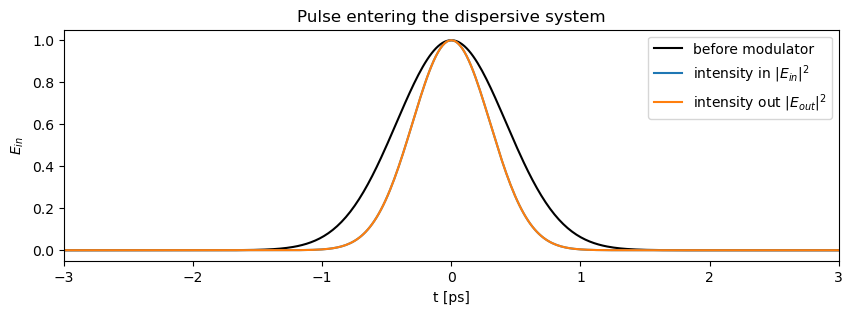

In [103]:
E_in_t = get_E_in(t=t_grid,t_FWHM=t_FWHM) #generating E filed entering the modulator
E_out_t = E_in_t*np.exp(-1j*Beta*np.cos(omega_p0*t_grid-delta_phi)) #E field of the pulse leaving the modulator

fig = plt.figure(figsize=(10,3))
plt.plot(t_grid*1e12,E_in_t,color='black',label='before modulator')
plt.plot(t_grid*1e12,np.abs(E_in_t)**2,label=r'intensity in $|E_{in}|^2$')
plt.plot(t_grid*1e12,np.abs(E_out_t)**2,label=r'intensity out $|E_{out}|^2$')
plt.xlabel('t [ps]')
plt.ylabel(r'$E_{in}$')
plt.xlim(-3*t_FWHM*1e12,3*t_FWHM*1e12)
plt.title('Pulse entering the dispersive system')
plt.legend()

Now I want to get 
\begin{equation}
    a(\omega)=\frac{1}{\sqrt{2\pi}}\int_{-inf}^{inf}\left[f(t)e^{-i\omega_0 t}\right]e^{i\omega t}dt = \frac{1}{\sqrt{2\pi}}\int_{-inf}^{inf}\left[e^{-\frac{1}{2}\left(\frac{t-t_0}{\sigma}\right)^2}e^{-i\omega_0 t}\right]e^{i\omega t}dt
\end{equation}
In other words, $a(\omega)$ is the fourier transform of $E_{in}(t)$, and should be possible to solve analytically. Sympy does not compile, however, and it's necessary to perform a discrete fourier transform. Again, the factor $e^{-i\omega_0 t}$ will be ignored for simplicity

# Effect of Modulator in Frequency space:

[1079, 1062, 1046, 1030, 1014, 999, 984]


Text(0.5, 0, 'wavelength [nm]')

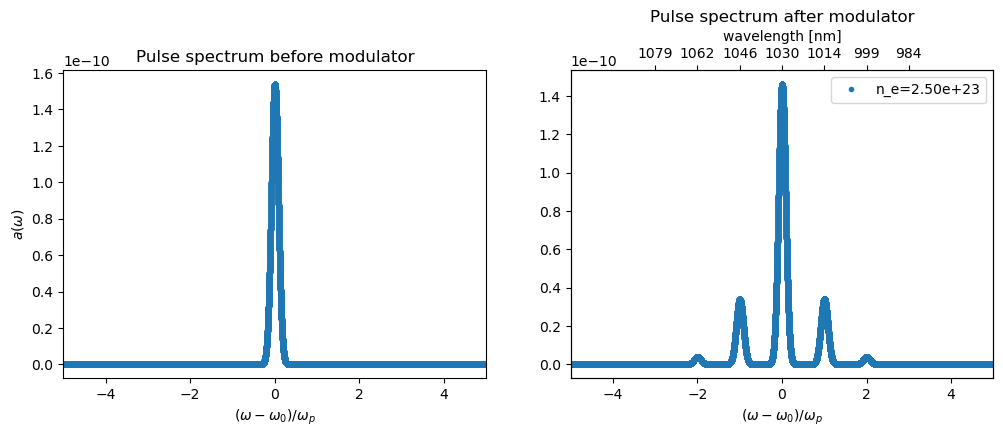

In [164]:
fig,axs=plt.subplots(1,2,figsize=(12,4),sharex=False)

b_in_omega = np.roll(np.sqrt(N/(2*np.pi))*delta_t_grid*fft(E_in_t),int(N/2))
b_out_omega = np.roll(np.sqrt(N/(2*np.pi))*delta_t_grid*fft(E_out_t),int(N/2))

axs[0].plot(omega_grid/omega_p0, np.abs(b_in_omega),'.')
axs[0].set_xlabel(r'$(\omega-\omega_0)/\omega_p$')
axs[0].set_ylabel(r'$a(\omega)$')
axs[0].set_title('Pulse spectrum before modulator')
axs[0].set_xlim(-5,5)
#axs[0].set_yscale('log')

axs[1].plot(omega_grid/omega_p0,np.abs(b_out_omega),'.',label=("n_e={:.2e}".format(n_e0)))
axs[1].set_xlabel(r'$(\omega-\omega_0)/\omega_p$')
axs[1].set_title("Pulse spectrum after modulator")

axs[1].legend()
axs[1].set_xlim(-5,5)

ax2=axs[1].twiny()
sidebands=[-3,-2,-1,0,1,2,3]
new_nm_ticks=[]
for n in sidebands:
    new_nm_ticks.append(np.int(2*np.pi*c/(omega_0+n*omega_p0)*1e9))
print(new_nm_ticks)
ax2.set_xlim(axs[1].get_xlim())
ax2.set_xticks(sidebands)
ax2.set_xticklabels(new_nm_ticks)
ax2.set_xlabel('wavelength [nm]')

In [118]:
print(2*np.pi*c/(omega_0-3*omega_p0))

1.0799674074398118e-06


The Sellmeier Equation is a semi-empirical formula refering to the index of refraction of a material:
\begin{equation}
n(\lambda)=\sqrt{1+A+\sum_i \frac{B_i\lambda^2}{\lambda^2-C_i}}
\end{equation}
where $B_i$, $C_i$ are experimentally found material-specific coefficients.
or, in terms of $\omega$:
\begin{equation}
n(\omega)=\sqrt{1+A+\frac{4\pi^2}{\omega^2}\sum_i \frac{B_i c^2}{\frac{4\pi^2c^2}{\omega^2}-C_i}}
\end{equation}
and the phase shift can be then expressed as 
\begin{equation}
    \phi(\omega)=\frac{\omega}{c}n(\omega)z=\frac{\omega z}{c}\sqrt{1+A+\frac{4\pi^2}{\omega^2}\sum_i \frac{B_i c^2}{\frac{4\pi^2c^2}{\omega^2}-C_i}}
\end{equation}

In [105]:
A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym,lambda_sym,lambda_micron_sym=symbols('A B_1 B_2 B_3 C_1 C_2 C_3 lambda lambda_mu',real=True)
c_sym,omega_sym=symbols('c omega',real=True)
lambda_sym = 2*smp.pi*c_sym/omega_sym
lambda_micron_sym = lambda_sym*1e6 #tabulated Sellmeier coefficients assume wavelength provided in microns
n_sellm_sym=smp.sqrt(1+A_sym+(B_1_sym*lambda_micron_sym**2)/(lambda_micron_sym**2-C_1_sym)+(B_2_sym*lambda_micron_sym**2)/(lambda_micron_sym**2-C_2_sym)+(B_3_sym*lambda_micron_sym**2)/(lambda_micron_sym**2-C_3_sym))
n_sellm_intermediate = smp.lambdify([omega_sym,c_sym,A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym],n_sellm_sym)

def n_sellm(omega,materials,mat_name):
    mat_info=materials[mat_name]
    A,B,C=mat_info[0],mat_info[1],mat_info[2]
    return n_sellm_intermediate(omega,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2])

n_sellm_sym

2000000.0*sqrt(2.5e-13*A + pi**2*B_1*c**2/(omega**2*(-C_1 + 4000000000000.0*pi**2*c**2/omega**2)) + pi**2*B_2*c**2/(omega**2*(-C_2 + 4000000000000.0*pi**2*c**2/omega**2)) + pi**2*B_3*c**2/(omega**2*(-C_3 + 4000000000000.0*pi**2*c**2/omega**2)) + 2.5e-13)

# Sellmeier Coefficients of Common Optical Materials:
taken from: https://refractiveindex.info/

In [106]:
# a dictionary of materials, including their Sellmeier coefficients as [A,[B_1,B_2,B_3],[C_1,C_2,C_3]]
materials={
    # GLASSES:
    'BK7': [0,[1.03961212,0.231792344,1.01046945],[0.00600069867,0.0200179144,103.560653]],
    "Infrasil": [0,[4.76523070e-1,6.27786368e-1,8.72274404e-1],[2.84888095e-3,1.18369052e-2,9.56856012e1]],
    "FusedSilica7980": [0,[0.68374049400,0.42032361300,0.58502748000],[0.00460352869,0.01339688560,64.49327320000]],
    'F2': [0,[1.34533359,0.209073176,0.937357162],[0.00997743871,0.0470450767,111.886764]], #https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=6973
    'LASF9': [0,[2.00029547,0.298926886,1.806918430],[0.01214260170,0.0538736236,156.5308290]],
    'BAF10': [0,[1.5851495,0.143559385,1.08521269],[0.00926681282,0.0424489805,105.613573]],
    'BAK1': [0,[1.12365662,0.309276848,0.881511957],[0.00644742752,0.0222284402,107.297751]],
    'FK51A': [0,[0.971247817,0.216901417,0.904651666],[0.00472301995,0.0153575612,168.68133]],
    'SF5': [0,[1.52481889,0.187085527,1.42729015],[0.011254756,0.0588995392,129.141675]],
    'SF10': [0,[1.62153902,0.256287842,1.64447552],[0.0122241457,0.0595736775,147.468793]],
    'SF11': [0,[1.73759695,0.313747346,1.89878101],[0.013188707,0.0623068142,155.23629]],
    'SHOTT_SK': [0,[1.28189012,0.257738258,0.96818604],[0.0072719164,0.0242823527,110.377773]],
    'SHOTT_SSK': [0,[1.4306027,0.153150554,1.01390904],[0.00823982975,0.0333736841,106.870822]],
    'SHOTT_BK': [0,[1.26538542,0.0144191073,1.00323028],[0.00813104078,0.0543303226,102.821166]],
    'SHOTT_BaK': [0,[1.12365662,0.309276848,0.881511957],[0.00644742752,0.0222284402,107.297751]],
    'SHOTT_FK': [0,[0.973346627,0.146642231,0.679304225],[0.00640795469,0.020565293,80.4965389]],
    'SHOTT_LaK': [0,[1.28773667,0.518244853,26.1756109],[0.0055754192,0.0223679524,1892.2533]],
    'SHOTT_PK': [0,[1.15610775,0.153229344,0.785618966],[0.00585597402,0.0194072416,140.537046]],
    'SHOTT_BaFS': [0,[1.53652081,0.156971102,1.30196815],[0.0108435729,0.0562278762,131.3397]],
    'SHOTT_SF': [0,[1.55912923,0.284246288,0.968842926],[0.0121481001,0.0534549042,112.174809]],
    'SHOTT_LaSF': [0,[2.00029547,0.298926886,1.80691843],[0.0121426017,0.0538736236,156.530829]],

    # FLUORIDES:
    'CsF': [0,[0.60,0.56,5.92],[0,0.121,78.74]],
    'CaF2': [0.33973 ,[0.69913,0.11994,4.35181],[0.09374,21.18,38.46]],#https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=6973
    'KF': [0,[0.55083,0.29162,3.60001],[0,0.126,51.55]],
    'Mg2F':[0,[0.41344023,0.50497499,2.4904862],[0.03684262,0.09076162,23.771995]],

    # OXIDES:
    'Al2O3_Sapphire': [0,[1.4313493,0.65054713,5.3414021],[0.0726631,0.1193242,18.028251]], #Sapphire

    # MISCELLANEOUS:
    'Si': [0,[10.6684293,0.0030434748,1.54133408],[0.301516485,1.13475115,1104]],
    'ZnSe': [-0.689818,[4.855169,0.673922,2.481890],[0.056359,0.056336,2222.114]]
}

In [107]:
omegas=omega_0+omega_grid #get a copy of omega grid, this time centered at omega_0 (noy zero)

# Using a set of 2 prisms:

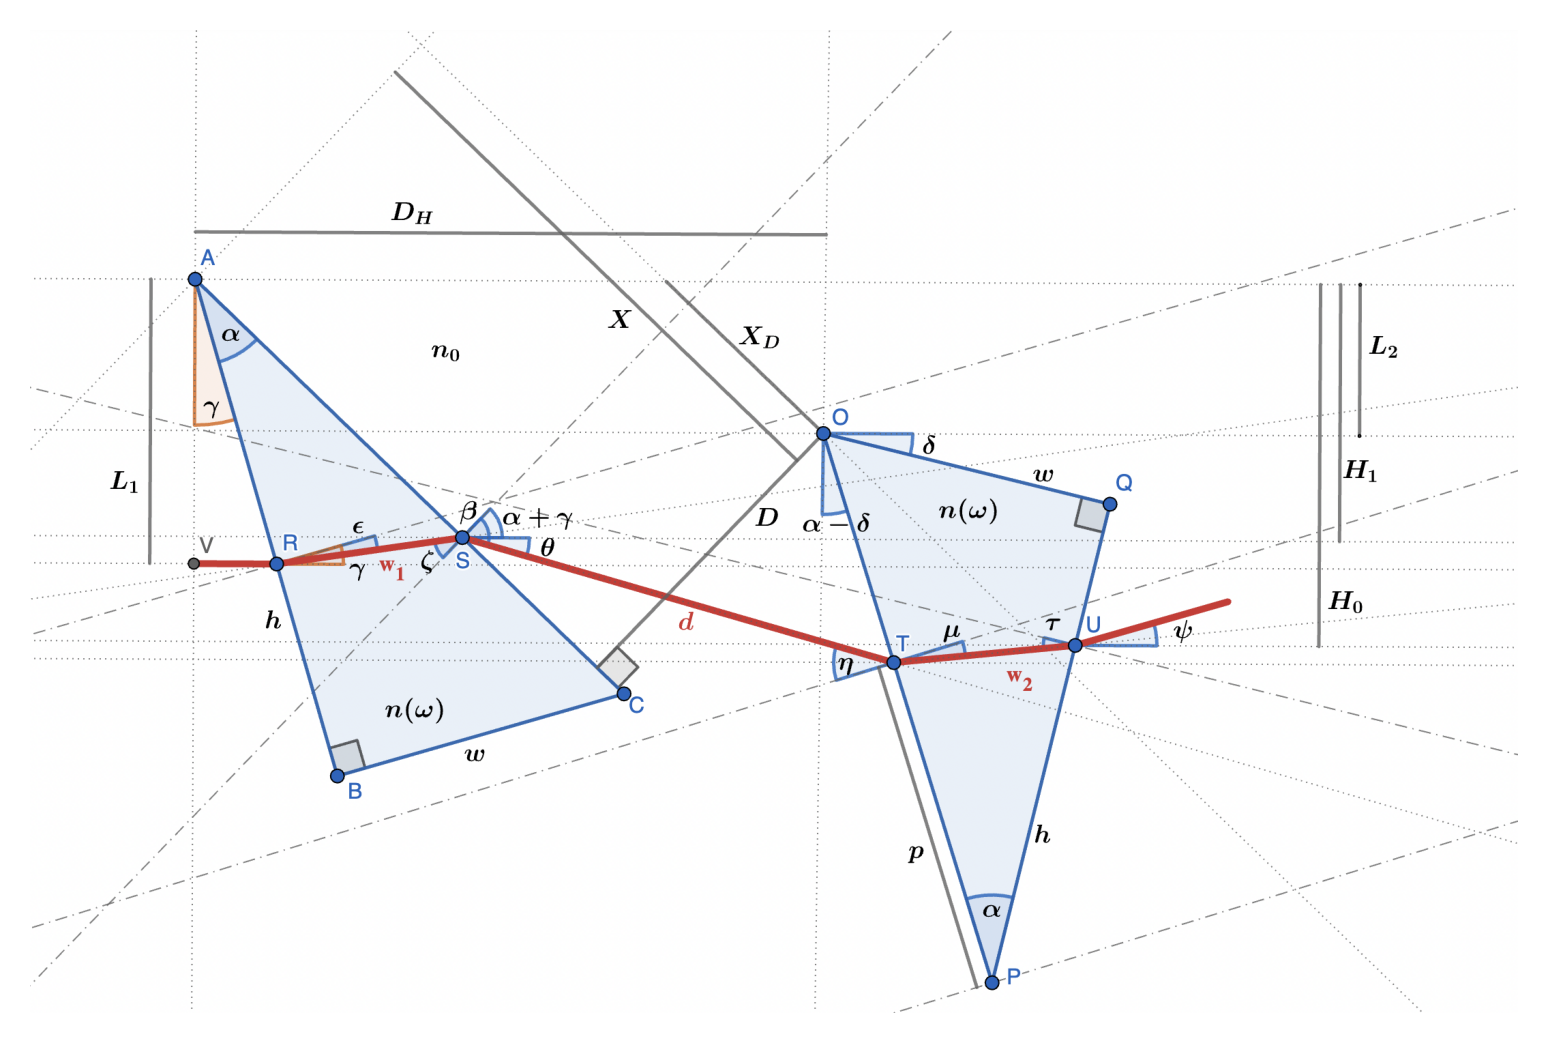

In [108]:
fig = plt.figure(dpi=300)
prism_img = plt.imread("prism_layout_general.png")
plt.axis('off')
plt.imshow(prism_img)

\begin{equation}
    \epsilon=\arcsin\left(\frac{n_0}{n(\omega)}\sin(\gamma)\right)
\end{equation}

\begin{equation}
    \zeta=\epsilon+\alpha
\end{equation}

\begin{equation}
    \beta=\arcsin\left(\frac{n(\omega)}{n_0}\sin(\zeta)\right)
\end{equation}

\begin{equation}
    \theta=\beta-\alpha-\gamma
\end{equation}

\begin{equation}
    \eta=\alpha+\theta-\delta
\end{equation}

\begin{equation}
    \mu=\arcsin\left(\frac{n_0}{n(\omega)}\sin(\eta)\right)
\end{equation}

\begin{equation}
    \tau=\alpha-\mu
\end{equation}

\begin{equation}
    w_1=\frac{\sin(\pi-\alpha-\gamma)}{\sin(\pi+\zeta)}L_1\left[\tan(\gamma+\alpha)-\tan(\gamma)\right]
\end{equation}

\begin{equation}
    H_1=L_1-w_1\sin(\gamma-\epsilon)
\end{equation}

\begin{equation}
    X_D=X-D\tan(\alpha+\gamma)
\end{equation}

\begin{equation}
    L_2=X_D\cos(\alpha+\gamma)
\end{equation}

\begin{equation}
    D_H=\frac{D}{\cos(\alpha+\gamma)}+X_D\sin(\alpha+\gamma)
\end{equation}

\begin{equation}
    d=\frac{\sin(\frac{\pi}{2}+\alpha-\delta)}{\sin(\frac{\pi}{2}+\delta-\alpha-\theta)}\left[D_H-L_1\tan(\gamma)-w_1\cos(\gamma-\epsilon)+(H_1-L_2)\tan(\alpha-\delta) \right]
\end{equation}

\begin{equation}
    p=\frac{L_2+w\sin(\delta)+h\cos(\delta)-L_1+w_1\sin(\gamma-\epsilon)-d\sin(\theta)}{\cos(\alpha-\delta)}
\end{equation}

\begin{equation}
    w_2=\frac{p\sin(\alpha)}{\sin(\frac{\pi}{2}-\alpha+\mu)}
\end{equation}

\begin{equation}
    \phi(\omega)=\frac{\omega}{c}\left[n(\omega)(w_1+w_2)+n_0d\right]
\end{equation}

The final formula is too involved (rather messy) to write analytically; instead, the analytical treatment is left for symPy to deal with, while we stick to defining the angles and dimensions using the variables derived one step before.

also, we want to make use of the Brewster's angle on the interface between the prisms/wedges and the space separating them. At CALA, the laser beam is (quite conveniently) polarized in the plane parallel to the optical table. This means that we require 

\begin{equation}
    \beta=\beta_{Brewster}=\arctan\left(\frac{n(\omega_0)}{n_0}\right)
\end{equation}
This puts restrictions on the prism's main (top corner) angle $\alpha$:
\begin{equation}
    \alpha_B=\arcsin\left[\frac{n_0}{n(\omega_0)}\sin\left(\arctan\left(\frac{n(\omega_0)}{n_0}\right)\right)\right]-\arcsin\left[\frac{n_0}{n(\omega_0)}\sin(\gamma)\right]
\end{equation} 
Conversely, this formula can be rewritten to find a suitable tilt angle $\gamma$ for an enforced prism apex angle $\alpha$. This version is perhaps more useful since prisms are usually manufactured using standard angles (i.e. 30 deg apex angle):

\begin{equation}
    \gamma_{REQ}=\arctan\left[\frac{n(\omega)}{n_0}\sin\left[\arcsin\left(\frac{n_0}{n(\omega)}\sin\left(\arctan\left(\frac{n(\omega_0)}{n_0}\right)\right)-\alpha\right)\right]\right]
\end{equation}

In [109]:
alpha_sym,gamma_sym,delta_sym,epsilon_sym,zeta_sym,beta_sym,theta_sym,eta_sym,mu_sym,tau_sym,psi_sym=symbols('alpha gamma delta epsilon zeta beta theta eta mu tau psi',real=True)
n_env_sym,n_sym,h_sym,L1_sym,L2_sym,D_sym=symbols('n0 n h L1 L2 D',real=True)
w_sym,w1_sym,H0_sym,H1_sym,d_sym,p_sym,w2_sym,X_sym,X_D_sym,D_H_sym=symbols('w w1 H0 H1 d p w2 X X_D D_H',real=True)
phi_sym=symbols('phi',real=True)

epsilon_sym=smp.asin(n_env_sym/n_sellm_sym*smp.sin(gamma_sym))
zeta_sym=epsilon_sym+alpha_sym
beta_sym=smp.asin(n_sellm_sym/n_env_sym*smp.sin(zeta_sym))
theta_sym=beta_sym-alpha_sym-gamma_sym
eta_sym=alpha_sym+theta_sym-delta_sym
mu_sym=smp.asin(n_env_sym/n_sellm_sym*smp.sin(eta_sym))
tau_sym=alpha_sym-mu_sym

w_sym=h_sym*smp.tan(alpha_sym)
w1_sym=L1_sym*(smp.tan(gamma_sym+alpha_sym)-smp.tan(gamma_sym))*smp.sin(smp.pi/2-gamma_sym-alpha_sym)/smp.sin(smp.pi/2+zeta_sym)
H1_sym=L1_sym-w1_sym*smp.sin(gamma_sym-epsilon_sym)
X_D_sym=X_sym-D_sym*smp.tan(alpha_sym+gamma_sym)
L2_sym=X_D_sym*smp.cos(alpha_sym+gamma_sym)
D_H_sym=D_sym/smp.cos(alpha_sym+gamma_sym)+X_D_sym*smp.sin(alpha_sym+gamma_sym)
d_sym=smp.sin(smp.pi/2+alpha_sym-delta_sym)/smp.sin(smp.pi/2+delta_sym-alpha_sym-theta_sym)*(D_sym-L1_sym*smp.tan(gamma_sym)-w1_sym*smp.cos(gamma_sym-epsilon_sym)+(H1_sym-L2_sym)*smp.tan(alpha_sym-delta_sym))
p_sym=(L2_sym+w_sym*smp.sin(delta_sym)+h_sym*smp.cos(delta_sym)-L1_sym+w1_sym*smp.sin(gamma_sym-epsilon_sym)-d_sym*smp.sin(theta_sym))/smp.cos(alpha_sym-delta_sym)
w2_sym=p_sym*smp.sin(alpha_sym)/(smp.sin(smp.pi/2-alpha_sym+mu_sym))
tau_sym=alpha_sym-mu_sym
psi_sym=smp.asin(n_sellm_sym/n_env_sym*smp.sin(tau_sym))-delta_sym

H0_sym=L1_sym-w1_sym*smp.sin(gamma_sym-epsilon_sym)+d_sym*smp.sin(theta_sym)-w2_sym*smp.sin(alpha_sym-delta_sym-mu_sym)
phi_sym=omega_sym/c_sym*(n_sellm_sym*(w1_sym+w2_sym)+n_env_sym*d_sym)
phi_prime_sym=smp.diff(phi_sym,omega_sym)

In [110]:
#create numerical function from symbolic expression for H, and use it so that Sellmeier coefficients can be nicely used
H0_interm=smp.lambdify([omega_sym,alpha_sym,D_sym,gamma_sym,delta_sym,c_sym,A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym,n_env_sym,L1_sym,X_sym,h_sym],H0_sym)
def H0_omega(omega,materials,mat_name,D,n_env,alpha,gamma,delta,L1,X,h):
    mat_info=materials[mat_name]
    A,B,C=mat_info[0],mat_info[1],mat_info[2]
    return H0_interm(omega,alpha,D,gamma,delta,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2],n_env,L1,X,h)

psi_interm=smp.lambdify([omega_sym,alpha_sym,D_sym,gamma_sym,delta_sym,c_sym,A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym,n_env_sym,L1_sym,X_sym,h_sym],psi_sym)
def psi_omega(omega,materials,mat_name,D,n_env,alpha,gamma,delta,L1,X,h):
    mat_info=materials[mat_name]
    A,B,C=mat_info[0],mat_info[1],mat_info[2]
    return psi_interm(omega,alpha,D,gamma,delta,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2],n_env,L1,X,h)

phi_interm=smp.lambdify([omega_sym,alpha_sym,D_sym,gamma_sym,delta_sym,c_sym,A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym,n_env_sym,L1_sym,X_sym,h_sym],phi_sym)
phi_prime_interm=smp.lambdify([omega_sym,alpha_sym,D_sym,gamma_sym,delta_sym,c_sym,A_sym,B_1_sym,B_2_sym,B_3_sym,C_1_sym,C_2_sym,C_3_sym,n_env_sym,L1_sym,X_sym,h_sym],phi_prime_sym)
def phase_shift(omega,materials,mat_name,D,n_env,alpha,gamma,delta,L1,X,h):
    mat_info=materials[mat_name]
    A,B,C=mat_info[0],mat_info[1],mat_info[2]
    T=phi_interm(omega,alpha,D,gamma,delta,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2],n_env,L1,X,h)
    T0=phi_interm(omega_0,alpha,D,gamma,delta,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2],n_env,L1,X,h)
    T1=phi_prime_interm(omega_0,alpha,D,gamma,delta,3e8,A,B[0],B[1],B[2],C[0],C[1],C[2],n_env,L1,X,h)*(omega-omega_0)
    return T-T0-T1 #subtract zeroth and first term in the Taylor expansion

In [111]:
# ideal phase shift calculation here:
ideal_phase,omega_0_sym = symbols('psi_m omega_0',real=True)
omega_p_sym = symbols('omega_p',real=True)
ideal_phase = smp.pi/2*smp.Abs((omega_sym-omega_0_sym)/omega_p_sym)
_ideal_phase = smp.lambdify([omega_sym,omega_0_sym,omega_p_sym],ideal_phase)

In [125]:
import warnings
@interact
def foo(n_e0=(1.0e23,5e23,0.1e23),delta_n_e_percent=(0,5,0.1),material=list(materials.keys()),P1_deg=(-2,2,0.1),P2_deg=(-2,2,0.1),alpha_deg=(0,60,1),L1_cm=(0,6,0.1),D_cm=(-0,2,0.1),X_cm=(-10,10,0.1)):
    fig, axs = plt.subplots(2,2,figsize=(14,7))

    X=X_cm/100
    L1=L1_cm/100
    D=D_cm/100
    n_env=1 #refractive index of the environment (i.e. vacuum or air)
    h=0.038
    r=0.1

    n = n_sellm(omega_0,materials,material)
    beta_brew=np.arctan(n/n_env) #Brewster's angle, specific for the material and the central wavelength

    # stuff for the nonlinear effects:
    chi_3=2.9e-22 #third order nonlinear optical succeptibility of BK7
    n2=9*np.pi/(n**2)*chi_3
    pulse_dur=1e-12 #1ps
    pulse_E=300e-3 #300 mJ ish
    beam_diam=5e-2 #5cm ish..?
    beam_area=np.pi/4*beam_diam**2
    I_intensity=pulse_E/pulse_dur/(beam_area)

    alpha=alpha_deg*np.pi/180
    P1_dev=P1_deg*np.pi/180
    P2_dev=P2_deg*np.pi/180
    #tilt= np.arcsin(n/n_env*np.sin(np.arcsin(n_env/n*np.sin(beta_brew))-alpha))#tilt angle gamma calculated based on given alpha so that Brewster angle is enforced.
    tilt=0

    gamma=tilt+P1_dev
    delta=-(tilt+P2_dev)

    #gamma=tilt_deg*np.pi/180
    #delta=-tilt_deg*np.pi/180
    #alpha=np.arcsin(n_env/n*np.sin(beta_brew))-np.arcsin(n_env/n*np.sin(gamma)) #prism angle alpha so that Beta is a Brewster angle

    epsilon=np.arcsin(n_env/n*np.sin(gamma))
    zeta=epsilon+alpha
    beta=np.arcsin(n/n_env*np.sin(zeta))
    theta=beta-alpha-gamma
    eta=alpha+theta-delta
    mu=np.arcsin(n_env/n*np.sin(eta))
    tau=alpha-mu
    psi=np.arcsin(n/n_env*np.sin(tau))-delta

    H0=H0_omega(omega_0,materials,material,D,n_env,alpha,gamma,delta,L1,X,h)
    H0_om=H0_omega(omegas,materials,material,D,n_env,alpha,gamma,delta,L1,X,h)

    w=h*np.tan(alpha)
    w1=L1*(np.tan(gamma+alpha)-np.tan(gamma))*np.sin(np.pi/2-gamma-alpha)/np.sin(np.pi/2+zeta)
    H1=L1-w1*np.sin(gamma-epsilon)
    X_D=X-D*np.tan(alpha+gamma)
    L2=X_D*np.cos(alpha+gamma)
    D_H=D/np.cos(alpha+gamma)+X_D*np.sin(alpha+gamma)
    d=np.sin(np.pi/2+alpha-delta)/np.sin(np.pi/2+delta-alpha-theta)*(D_H-L1*np.tan(gamma)-w1*np.cos(gamma-epsilon)+(H1-L2)*np.tan(alpha-delta))
    p=(L2+w*np.sin(delta)+h*np.cos(delta)-L1+w1*np.sin(gamma-epsilon)-d*np.sin(theta))/np.cos(alpha-delta)
    w2=p*np.sin(alpha)/(np.sin(np.pi/2-alpha+mu))

    B_int=2*np.pi/lambda_0*n2*I_intensity*(w1+w2) # B integral

    A=[0,0]
    B=[A[0]+h*np.sin(gamma),A[1]-h*np.cos(gamma)]
    C=[B[0]+w*np.cos(gamma),B[1]+w*np.sin(gamma)]

    O=[A[0]+D_H,A[1]-L2]
    Q=[O[0]+w*np.cos(delta),O[1]-w*np.sin(delta)]
    P=[Q[0]-h*np.sin(delta),Q[1]-h*np.cos(delta)]

    V=[A[0]-0.1,A[1]-L1]
    R=[A[0]+L1*np.tan(gamma),V[1]]
    S=[R[0]+w1*np.cos(gamma-epsilon),R[1]+w1*np.sin(gamma-epsilon)]
    T=[S[0]+d*np.cos(theta),S[1]-d*np.sin(theta)]
    U=[T[0]+w2*np.cos(alpha-delta-mu),T[1]+w2*np.sin(alpha-delta-mu)]
    #U=[T[0]+w2*np.cos(alpha-delta-mu),-H0]
    W=[U[0]+r*np.cos(psi),U[1]+r*np.sin(psi)]


    diam_max=np.abs(P[1]) #max diameter of the beam that the specific setting allows

    P1 = np.array([A,B,C])
    P2 = np.array([O,P,Q])
    axs[0,0].scatter(P1[:, 0], P1[:, 1], s = 0, color = 'grey')
    axs[0,0].scatter(P2[:, 0], P2[:, 1], s = 0, color = 'grey')
    t1 = plt.Polygon(P1[:3,:], color='grey')
    t2 = plt.Polygon(P2[:3,:], color='grey')
    axs[0,0].add_patch(t1)
    axs[0,0].add_patch(t2)

    axs[0,0].plot([V[0],R[0]],[V[1],R[1]],color='black')
    axs[0,0].plot([R[0],S[0]],[R[1],S[1]],color='black')
    axs[0,0].plot([S[0],T[0]],[S[1],T[1]],color='black')
    axs[0,0].plot([T[0],U[0]],[T[1],U[1]],color='black')
    axs[0,0].plot([U[0],W[0]],[U[1],W[1]],color='black')

    axs[0,0].axhline(y=0,linestyle='dotted',linewidth=1,color='black')
    axs[0,0].axvline(x=0,linestyle='dotted',linewidth=1,color='black')

    axs[0,0].set_xlim(-0.05,0.30)
    axs[0,0].set_ylim(-1.5*h,0.05)
    xtickslocs=axs[0,0].get_xticks()
    ytickslocs=axs[0,0].get_yticks()
    axs[0,0].set_xticklabels(list(map(int, xtickslocs*100)))
    axs[0,0].set_yticklabels(list(map(int, ytickslocs*100)))
    axs[0,0].xaxis.set_label_position('top') 
    axs[0,0].xaxis.set_ticks_position('top')
    axs[0,0].set_xlabel('X [cm]')
    axs[0,0].set_ylabel('Y [cm]')
    axs[0,0].set_aspect('equal')

    axs[0,0].text(s='tilt = '+str(np.round(tilt*180/np.pi,2))+r'$^o$',x=0.1,y=0.01)
    axs[0,0].text(s=r'$\beta$ = '+str(np.round(beta*180/np.pi,2))+r'$^o$',x=0.1,y=0.02)
    axs[0,0].text(s=r'B = '+str(np.round(B_int,2)),x=0.1,y=0.03)

    axs[0,0].axhline(y=-diam_max,linestyle='dotted',linewidth=1,color='black')
    axs[0,0].text(s=r'$D_{max}$ = '+str(np.round(diam_max*100,2))+r' cm',x=0.1,y=-diam_max+0.005)

    #####################
    # SPATIAL CHIRP PLOT
    omega_p0 = np.sqrt(n_e0*q**2/(m_e*epsilon_0)) #plasma frequency on axis, required for x-axis scaling, etc.

    psi_om=psi_omega(omegas,materials,material,D,n_env,alpha,gamma,delta,L1,X,h)
    psi_om_0=psi_omega(omega_0,materials,material,D,n_env,alpha,gamma,delta,L1,X,h)
    #print(psi_om[0:10])


    ax2 = axs[0,1].twinx()
    axs[0,1].axhline(y=(np.abs(U[1])-np.abs(L1))*1000)
    axs[0,1].set_ylim(-20,20)
    axs[0,1].set_ylabel(r'walk-off ($H_0-L_1$) [mm]',color='tab:blue')

    ax2.plot((omegas-omega_0)/omega_p0,(H0_om-H0)*1e6,color='green')
    ax2.set_xlabel(r'$(\omega-\omega_0)/\omega_p$')
    ax2.set_ylabel(r'$\Delta H$ [$\mu$m]',color='green')
    ax2.set_ylim(-100,100)
    ax2.set_title('Walk-off and spatial chirp')
    ax2.axhline(y=0,linestyle='dotted',linewidth=1,color='black')

    #####################
    # PHASE SHIFT PLOT

    ideal_shift = _ideal_phase(omegas,omega_0,omega_p0) # calculating the ideal shift using a function defined above
    shift=phase_shift(omegas,materials,material,D,n_env,alpha,gamma,delta,L1,X,h)
    axs[1,0].plot((omegas-omega_0)/omega_p0,ideal_shift,color='red',label=r'ideal shift $\psi=\left|\frac{\omega-\omega_0}{\omega_p}\right|\frac{\pi}{2}$')
    axs[1,0].plot((omegas-omega_0)/omega_p0,shift,color='blue',label='shift from prism pair')
    axs[1,0].legend(loc='upper center')
    axs[1,0].set_xlabel(r'$(\omega-\omega_0)/\omega_p$')
    axs[1,0].set_ylabel(r'$\Delta \phi (\omega)$')
    axs[1,0].set_ylim(-2,12)
    axs[1,0].set_title(r'phase shift (without $0^{th},1^{st}$ order of the Taylor expansion)')

    #####################
    # PULSE TRAIN PLOT
    delta_n_e=delta_n_e_percent*1e-2
    T_p = 2*np.pi/omega_p0 #plasma period
    Beta = 1/2*omega_p0**2/omega_0*delta_n_e*L_mod/c #beta parameter of modulator
    E_out_t = E_in_t*np.exp(-1j*Beta*np.cos(omega_p0*t_grid-delta_phi)) #Electic field after the modulator
    a_out_omega = np.roll(np.sqrt(N/(2*np.pi))*delta_t_grid*fft(E_out_t),int(N/2)) #frequency spectrum after the modulator

    a_omega_out_ideal=[] #initialize new array for modulated frequency spectrum, with the ideal phase shift
    for a_val,phi_val in zip(a_out_omega,ideal_shift): #add the ideal phase to the frequency spectrum (ideal shift centered at 0)
        a_omega_out_ideal.append(a_val*np.exp(1j*phi_val))

    new_a_out_omega = [] # initialize new array for frequency spectrum after dispersion
    for b_val,phi_val in zip(a_out_omega,shift): #add the phase arising from the dispersion system to the frequancy spectrum after modulator
        new_a_out_omega.append(b_val*np.exp(1j*phi_val))

    b_ideal_t = np.sqrt(N/(2*np.pi))*delta_omega_grid*ifft(np.roll(a_omega_out_ideal,-int(N/2))) #go back to time domain, ideal shift case
    b_comp_t = np.sqrt(N/(2*np.pi))*delta_omega_grid*ifft(np.roll(new_a_out_omega,-int(N/2))) #go back to time domain, dispersion system case

    axs[1,1].plot(t_grid/T_p,np.abs(b_ideal_t)**2,'.-',color='red',label='with ideal phase shift')
    axs[1,1].plot(t_grid/T_p,np.abs(b_comp_t)**2,'.-',color='blue',label='after prism pair')
    axs[1,1].set_xlabel(r'$t/\tau_p$')
    axs[1,1].set_xlim(-8,8)
    axs[1,1].legend(loc="upper right")
    axs[1,1].set_ylabel(r'intensity $|b|^2$')
    axs[1,1].set_ylim(0,6)
    axs[1,1].set_ylabel(r'intensity $|b|^2$')

    warnings.filterwarnings("ignore")


interactive(children=(FloatSlider(value=2.9999999999999997e+23, description='n_e0', max=5e+23, min=1e+23, step…